<center>
<img src="./images/lda-pic.png" height="800" width="500"/>

#  Linear Discriminant Analysis

This is copy of the Chapter 5 from the book **Python Machine Learning** by Sebastian Raschka and Vahid Mirjalili.

**LDA** can be used as a technique for feature extraction to increase the computational
efficiency and reduce the degree of overfitting due to the curse of dimensionality in
non-regularized models.

The general concept behind LDA is very similar to PCA, but whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes
class separability. In the following sections, we will discuss the similarities between LDA and PCA in more detail and walk through the LDA approach step by step.


## Principal component analysis versus linear discriminant analysis



Both PCA and LDA are linear transformation techniques that can be used to reduce the number of dimensions in a dataset; the former is an unsupervised algorithm, whereas the latter is supervised. Thus, we might think that LDA is a superior feature extraction technique for classification tasks compared to PCA. However, *A.M. Martinez* reported that preprocessing via PCA tends to result in better classification results in an image recognition task in certain cases, for instance, if each class consists of only a small number of examples.

**Fisher LDA**

LDA is sometimes also called Fisher's LDA. **Ronald A. Fisher**
initially formulated Fisher's Linear Discriminant for two-class classification problems in 1936 (The Use of Multiple Measurements in Taxonomic Problems, R. A. Fisher, Annals of Eugenics, 7(2): 179-
188, 1936). Fisher's linear discriminant was later generalized for multi-class problems by **C. Radhakrishna Rao** under the assumption of equal class covariances and normally distributed classes in 1948, which we now call LDA (The Utilization of Multiple Measurements in Problems of Biological Classification, C. R. Rao, Journal of the Royal Statistical Society. Series B (Methodological), 10(2): 159-203, 1948).

One assumption in LDA is that the data is normally distributed. Also, we assume
that the classes have identical covariance matrices and that the training examples
are statistically independent of each other. However, even if one, or more, of those
assumptions is (slightly) violated, LDA for dimensionality reduction can still work
reasonably well.


## The inner workings of linear discriminant analysis


Before we dive into the code implementation, let's briefly summarize the main steps
that are required to perform LDA:

1. Standardize the $d$-dimensional dataset ($d$ is the number of features).
2. For each class, compute the $d$-dimensional mean vector.
3. Construct matrix, the between-class scatter matrix, $S_B$, and the within-class scatter $S_W$.
4. Compute the eigenvectors and corresponding eigenvalues of the matrix, $S_{W}^{−1}S_B$.
5. Sort  the eigenvalues by decreasing order to rank the corresponding eigenvectors.
6. Choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues to construct a $x \times k$-dimensional transformation matrix, $W$; the eigenvectors are the columns a of his matrix.
7. Project the examples onto the new feature subspace using the transformation matrix, $W$.


LDA is quite similar to PCA in the sense that we are decomposing
matrices into eigenvalues and eigenvectors, which will form the new lower-
dimensional feature space. However, as mentioned before, LDA takes class label
information into account, which is represented in the form of the mean vectors
computed in step 2. In the following sections, we will discuss these seven steps in
more detail, accompanied by illustrative code implementations.


## Computing the scatter matrices

First we must standardize the features of the Wine dataset and then we proceed with the calculation of the mean vectors, which we will use to construct the within-class scatter matrix and between-class scatter matrix, scatter with respect matrix, to respectively. Each mean vector $m_i$, stores the mean feature values, $\mu_m$, with respect to the examples of class $i$:

$$m_i = \dfrac{1}{n_i}\sum_{x \in D_i} x_m$$

This results in three mean vectors:

$$\begin{align}
    m_i &= \begin{bmatrix}
           \mu_{i, alcohol} \\
           \mu_{i, malic\;acid} \\
           \vdots \\
           \mu_{i, proline}
         \end{bmatrix}
         \quad i \in {1, 2, 3}
  \end{align}$$

In [2]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3,
                  stratify=y,
                  random_state=0)

# standardize the features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
import numpy as np

np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Using the mean vectors, we can now compute the within-class scatter matrix, $S_W$:

$$S_W = \sum_{i=1}^c S_i$$

This individual is calculated class $i$: by summing up the individual scatter matrices, $S_i$, of each individual class $i$:

$$S_i = \sum_{x \in D_i} (x-m_i)(x-m_i)^{T}$$


In [6]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
        S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


The assumption that we are making when we are computing the scatter matrices is
that the class labels in the training dataset are uniformly distributed. However, if we
print the number of class labels, we see that this assumption is violated:


In [9]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


Thus, we want to scale the individual scatter matrices, $S_i$, before we sum them up as scatter matrix $S_W$. When we divide the scatter matrices by the number of class-example, $n_i$, we can see that the scatter matrix is in fact the same as computing the covariance matrix, $\Sigma_i$ - the covariance matrix in a normalized version of the scatter matrix:

$$\Sigma_i = \dfrac{1}{n_i}S_i = \dfrac{1}{n_i}\sum_{x \in D_i} (x - m_i)(x - m_i)^T$$

The code for computing the scaled within-class scatter matrix is as follows:

In [10]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label,mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


After we compute the scaled within-class scatter matrix (or covariance matrix),
we can move on to the next step and compute the between-class scatter matrix $S_B$:

$$S_B = \sum_{i=1}^c n_i(m_i - m)(m_i - m)^T$$

Here, $m$ is the overall mean that is computed, including examples from all $c$ classes.

In [12]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


## Selecting linear discriminants for the new feature subspace

The remaining steps of the LDA are similar to the steps of the PCA. However, instead of performing the eigendecomposition on the covariance matrix, we solve
the generalized eigenvalue problem of the matrix, $S_W^{-1}S_B$.

In [14]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

After we compute the eigenpairs, we can sort the eigenvalues in descending order:

In [15]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
               for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


In LDA, the number of linear discriminants is at most $c−1$, where $c$ is the number of class one labels, since the in-between scatter matrix, $S_B$, is the sum of $c$ matrices with rank one or less. We can indeed see that  we only have two nonzero eigenvalues (the eigenvalues 3-13 are not exactly zero, but this is due to the floating-point arithmetic in NumPy).

**Collinearity**

<span style="color:purple"> 
Note that in the rare case of perfect collinearity (all aligned example points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue.
</span>

To measure how much of the class-discriminatory information is captured by the linear discriminants (eigenvectors), let's plot the linear discriminants by decreasing eigenvalues, similar to the explained variance plot that we created in the PCA section. For simplicity, we will call the content of class-discriminatory information discriminability:



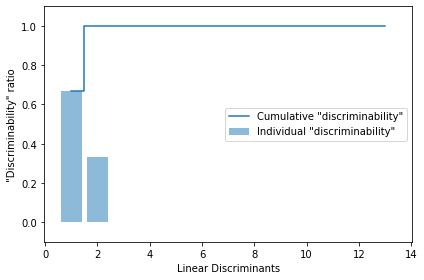

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center',
label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout();

As we can see in the resulting figure, the first two linear discriminants alone capture
100 percent of the useful information in the Wine training dataset.

Let's now stack the two most discriminative eigenvector columns to create the
transformation matrix, $W$:

In [23]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


## Projecting examples onto the new feature space

Using the transformation matrix, $W$, that we created in the previous subsection,
we can now transform the training dataset by multiplying the matrices:

$$X^{'} = XW$$

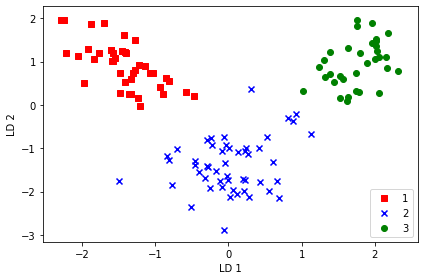

In [24]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
     plt.scatter(X_train_lda[y_train==l, 0],
                 X_train_lda[y_train==l, 1] * (-1),
                 c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

As we can see in the resulting plot, the three Wine classes are now perfectly linearly
separable in the new feature subspace.

## LDA via scikit-learn

That step-by-step implementation was a good exercise to understand the inner
workings of an LDA and understand the differences between LDA and PCA. Now,
let's look at the LDA class implemented in scikit-learn:

In [25]:
# the following import statement is one line
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

Next, let's see how the logistic regression classifier handles the lower-dimensional
training dataset after the LDA transformation:

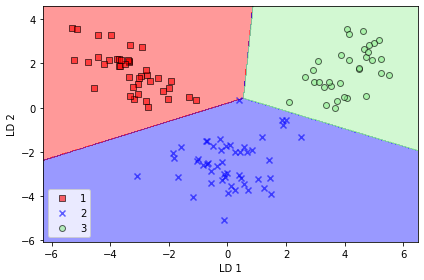

In [29]:
from sklearn.linear_model import LogisticRegression
from plot_regions import plot_decision_regions

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()

By lowering the regularization strength, we could probably shift the decision
boundaries so that the logistic regression model classifies all examples in the training
dataset correctly. However, and more importantly, let's take a look at the results on
the test dataset:

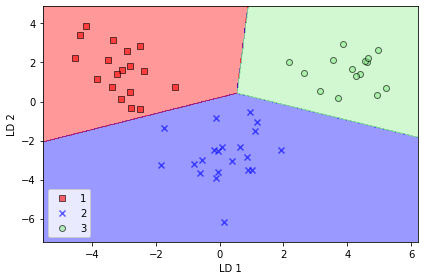

In [30]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()

As we can see in the following plot, the logistic regression classifier is able to get
a perfect accuracy score for classifying the examples in the test dataset by only
using a two-dimensional feature subspace, instead of the original 13 Wine features